## Импорт библиотек

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

from collections import Counter
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report, roc_curve
from catboost import CatBoostClassifier

## Загрузка и Предобработка данных

In [2]:
data = pd.read_excel('./data/train.xlsx', index_col=0)
data_clean = data.copy()
data_test = pd.read_excel('./data/test.xlsx', index_col=0)
lf_weather_12 = pd.read_excel('./data/погода_сосновомежду_игоро_и_приозерском.xls', skiprows=6)
lf_weather_3 = pd.read_excel('./data/погода сортавало.xls', skiprows=6)
lf_weather_4 = pd.read_excel('./data/погода видлица.xls', skiprows=6)
data.head(3)

,№ брони,Номеров,Стоимость,Внесена предоплата,Способ оплаты,Дата бронирования,Дата отмены,Заезд,Ночей,Выезд,Источник,Статус брони,Категория номера,Гостей,Гостиница
0,20230428-6634-194809261,1,25700.0,0,Внешняя система оплаты,2023-04-20 20:37:30,2023-04-20 20:39:15,2023-04-28 15:00:00,3,2023-05-01 12:00:00,Яндекс.Путешествия,Отмена,Номер «Стандарт»,2,1
1,20220711-6634-144460018,1,24800.0,12400,Отложенная электронная оплата: Банк Россия (ба...,2022-06-18 14:17:02,NaT,2022-07-11 15:00:00,2,2022-07-13 12:00:00,Официальный сайт,Активный,Номер «Стандарт»,2,1
2,20221204-16563-171020423,1,25800.0,12900,Банк. карта: Банк Россия (банк. карта),2022-11-14 22:59:30,NaT,2022-12-04 15:00:00,2,2022-12-06 12:00:00,Официальный сайт,Активный,Номер «Студия»,2,4


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 26174 entries, 0 to 26173
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   № брони             26174 non-null  object        
 1   Номеров             26174 non-null  int64         
 2   Стоимость           26174 non-null  float64       
 3   Внесена предоплата  26174 non-null  int64         
 4   Способ оплаты       26174 non-null  object        
 5   Дата бронирования   26174 non-null  datetime64[ns]
 6   Дата отмены         5192 non-null   datetime64[ns]
 7   Заезд               26174 non-null  datetime64[ns]
 8   Ночей               26174 non-null  int64         
 9   Выезд               26174 non-null  datetime64[ns]
 10  Источник            26174 non-null  object        
 11  Статус брони        26174 non-null  object        
 12  Категория номера    26174 non-null  object        
 13  Гостей              26174 non-null  int64         


In [4]:
for i in data.select_dtypes('object').columns:
    print(f"Уникальные значения для столбца {i}: {data[i].unique()}\n\n\n")

Уникальные значения для столбца № брони: ['20230428-6634-194809261' '20220711-6634-144460018'
 '20221204-16563-171020423' ... '20220624-7492-137587082'
 '20220427-7491-125459150' '20220816-6634-155783156']



Уникальные значения для столбца Способ оплаты: ['Внешняя система оплаты'
 'Отложенная электронная оплата: Банк Россия (банк. карта)'
 'Банк. карта: Банк Россия (банк. карта)'
 'Внешняя система оплаты (С предоплатой)'
 'Система быстрых платежей: Эквайринг ComfortBooking (Система быстрых платежей)'
 'Гарантия банковской картой' 'Внешняя система оплаты (Оплата наличными)'
 'Банк. карта [Кешбэк. МИР]: Эквайринг TravelLine Pro (Банк. карта)'
 'При заселении' 'Банк. карта: Эквайринг ComfortBooking (Банк. карта)'
 'Банк. карта [Кешбэк. МИР]: Эквайринг ComfortBooking (Банк. карта)'
 'Банк. карта (SberPay): Эквайринг ComfortBooking (Банк. карта) (SberPay)'
 'Внешняя система оплаты (Банковская карта)'
 'Банк. карта (Yandex Pay): Эквайринг ComfortBooking (Банк. карта) (Yandex Pay)']



Уника

In [5]:
lf_weather_12.head(3)

,Местное время в Волосово,T,Po,P,Pa,U,DD,Ff,ff10,ff3,...,Cm,Ch,VV,Td,RRR,tR,E,Tg,E',sss
0,20.09.2024 18:00,18.1,757.9,769.3,NaN,75.0,"Ветер, дующий с запада",5,NaN,NaN,...,"Высококучевых, высокослоистых или слоисто-дожд...","Перистые нитевидные, иногда когтевидные, не ра...",10.0,13.5,Осадков нет,12.0,NaN,NaN,NaN,NaN
1,20.09.2024 15:00,20.0,758.9,770.3,NaN,65.0,"Ветер, дующий с запада",4,NaN,NaN,...,"Высококучевых, высокослоистых или слоисто-дожд...","Перистые нитевидные, иногда когтевидные, не ра...",10.0,13.3,NaN,NaN,NaN,NaN,NaN,NaN
2,20.09.2024 12:00,17.4,759.4,770.9,NaN,87.0,"Ветер, дующий с запада",5,NaN,NaN,...,"Высококучевых, высокослоистых или слоисто-дожд...","Перистые нитевидные, иногда когтевидные, не ра...",10.0,15.2,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
data['Дата бронирования'] = pd.to_datetime(data['Дата бронирования'], errors='coerce')
lf_weather_12['Дата'] = pd.to_datetime(lf_weather_12['Местное время в Волосово'], errors='coerce')
lf_weather_3['Дата'] = pd.to_datetime(lf_weather_3['Местное время в г. Сортавала'], errors='coerce')
lf_weather_4['Дата'] = pd.to_datetime(lf_weather_4['Местное время в Олонце'], errors='coerce')

def average_temperature_between_dates(row):
    start_date = row['Дата бронирования']
    end_date = row['Заезд']
    
    if row['Гостиница'] in [1, 2]:
        mask = (lf_weather_12['Дата'] >= start_date) & (lf_weather_12['Дата'] <= end_date)
        selected_weather = lf_weather_12.loc[mask]
    elif row['Гостиница'] == 3:
        mask = (lf_weather_3['Дата'] >= start_date) & (lf_weather_3['Дата'] <= end_date)
        selected_weather = lf_weather_3.loc[mask]
    elif row['Гостиница'] == 4:
        mask = (lf_weather_4['Дата'] >= start_date) & (lf_weather_4['Дата'] <= end_date)
        selected_weather = lf_weather_4.loc[mask]
    
    if not selected_weather.empty:
        return selected_weather['T'].dropna().mean(), selected_weather['Pa'].dropna().mean()
    else:
        return None

data[['Средняя температура', 'Среднее давление']] = data.apply(
    lambda row: pd.Series(average_temperature_between_dates(row)), axis=1
)
data_test[['Средняя температура', 'Среднее давление']] = data_test.apply(
    lambda row: pd.Series(average_temperature_between_dates(row)), axis=1
)
data.head(3)

/tmp/ipykernel_1277618/1608236769.py:2: UserWarning: Parsing dates in %d.%m.%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  lf_weather_12['Дата'] = pd.to_datetime(lf_weather_12['Местное время в Волосово'], errors='coerce')
/tmp/ipykernel_1277618/1608236769.py:3: UserWarning: Parsing dates in %d.%m.%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  lf_weather_3['Дата'] = pd.to_datetime(lf_weather_3['Местное время в г. Сортавала'], errors='coerce')
/tmp/ipykernel_1277618/1608236769.py:4: UserWarning: Parsing dates in %d.%m.%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  lf_weather_4['Дата'] = pd.to_datetime(lf_weather_4['Местное время в Олонце'], errors='coerce')


,№ брони,Номеров,Стоимость,Внесена предоплата,Способ оплаты,Дата бронирования,Дата отмены,Заезд,Ночей,Выезд,Источник,Статус брони,Категория номера,Гостей,Гостиница,Средняя температура,Среднее давление
0,20230428-6634-194809261,1,25700.0,0,Внешняя система оплаты,2023-04-20 20:37:30,2023-04-20 20:39:15,2023-04-28 15:00:00,3,2023-05-01 12:00:00,Яндекс.Путешествия,Отмена,Номер «Стандарт»,2,1,10.212903,-0.436364
1,20220711-6634-144460018,1,24800.0,12400,Отложенная электронная оплата: Банк Россия (ба...,2022-06-18 14:17:02,NaT,2022-07-11 15:00:00,2,2022-07-13 12:00:00,Официальный сайт,Активный,Номер «Стандарт»,2,1,18.574860,NaN
2,20221204-16563-171020423,1,25800.0,12900,Банк. карта: Банк Россия (банк. карта),2022-11-14 22:59:30,NaT,2022-12-04 15:00:00,2,2022-12-06 12:00:00,Официальный сайт,Активный,Номер «Студия»,2,4,-6.139241,0.077848


In [7]:
data['Отмена'] = data['Дата отмены'].notnull().astype(int)
data['Гостиница'] = data['Гостиница'].astype(str)
data.drop('Дата отмены', axis=1, inplace=True)

data_test['Гостиница'] = data_test['Гостиница'].astype(str)

In [8]:
data.loc[data['Источник'].str.contains('Alean.ru', na=False), 'Источник'] = 'Alean.ru'
data_test.loc[data_test['Источник'].str.contains('Alean.ru', na=False), 'Источник'] = 'Alean.ru'

In [9]:
data['Внесена предоплата'] = (data['Внесена предоплата']) / data['Стоимость']
data['День недели заезда'] = data['Заезд'].dt.dayofweek
data.drop(columns='Стоимость', inplace=True)

data_test['Внесена предоплата'] = (data_test['Внесена предоплата']) / data_test['Стоимость']
data_test['День недели заезда'] = data_test['Заезд'].dt.dayofweek
data_test.drop(columns='Стоимость', inplace=True)

In [10]:
def split_and_clean_categories(row):
    categories = row.split('\n') if '\n' in row else [row]
    cleaned_categories = [re.sub(r'^\d+\.\s*', '', cat) for cat in categories]
    most_common_category = Counter(cleaned_categories).most_common(1)[0][0]
    return most_common_category

data['Категория номера'] = data['Категория номера'].apply(split_and_clean_categories)
data_test['Категория номера'] = data_test['Категория номера'].apply(split_and_clean_categories)
print(data['Категория номера'].value_counts())

Категория номера
Номер «Стандарт»                                      17060
Номер «Студия»                                         4929
Апартаменты с 2 спальнями с отдельным входом           1977
Номер «Люкс»                                            771
Коттедж с 2 спальнями                                   728
Коттедж с 3 спальнями                                   684
Номер «Стандарт» для маломобильных групп населения       25
Name: count, dtype: int64


In [11]:
data['Длительность пребывания'] = (data['Выезд'] - data['Заезд']).dt.total_seconds() / 3600
data['Время до заезда'] = (data['Заезд'] - data['Дата бронирования']).dt.total_seconds() // 3600
data.drop(columns=['Ночей'], inplace=True)

data_test['Длительность пребывания'] = (data_test['Выезд'] - data_test['Заезд']).dt.total_seconds() / 3600
data_test['Время до заезда'] = (data_test['Заезд'] - data_test['Дата бронирования']).dt.total_seconds() // 3600
data_test.drop(columns=['Ночей'], inplace=True)

In [12]:
data['День недели бронирования'] = data['Дата бронирования'].dt.dayofweek
data['Месяц заезда'] = data['Заезд'].dt.month

data_test['День недели бронирования'] = data_test['Дата бронирования'].dt.dayofweek
data_test['Месяц заезда'] = data_test['Заезд'].dt.month

## Деление данных и Обучение моделей

In [13]:
X, y = data.drop(columns=['№ брони', 'Статус брони', 'Отмена']), data['Отмена']
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

In [14]:
cat = CatBoostClassifier(verbose=False, random_state=42)
cat.fit(X_train, y_train, cat_features=X.select_dtypes('object').columns.tolist(), verbose=50)

Learning rate set to 0.037756
0:	learn: 0.6613061	total: 53.4ms	remaining: 53.4s
50:	learn: 0.3053349	total: 353ms	remaining: 6.56s
100:	learn: 0.2930671	total: 641ms	remaining: 5.7s
150:	learn: 0.2884177	total: 926ms	remaining: 5.21s
200:	learn: 0.2841500	total: 1.22s	remaining: 4.85s
250:	learn: 0.2802025	total: 1.52s	remaining: 4.54s
300:	learn: 0.2763939	total: 1.83s	remaining: 4.24s
350:	learn: 0.2729086	total: 2.14s	remaining: 3.95s
400:	learn: 0.2692263	total: 2.45s	remaining: 3.66s
450:	learn: 0.2660650	total: 2.77s	remaining: 3.37s
500:	learn: 0.2630989	total: 3.08s	remaining: 3.07s
550:	learn: 0.2599824	total: 3.4s	remaining: 2.77s
600:	learn: 0.2570825	total: 3.72s	remaining: 2.47s
650:	learn: 0.2546350	total: 4.03s	remaining: 2.16s
700:	learn: 0.2516399	total: 4.35s	remaining: 1.86s
750:	learn: 0.2490123	total: 4.67s	remaining: 1.55s
800:	learn: 0.2466581	total: 4.98s	remaining: 1.24s
850:	learn: 0.2444090	total: 5.3s	remaining: 928ms
900:	learn: 0.2419939	total: 5.62s	rema

In [15]:
y_pred_final = cat.predict_proba(X_valid)[:, 1]
roc_auc_final = roc_auc_score(y_valid, y_pred_final)
print(f'ROC-AUC финальной модели CatBoost: {roc_auc_final:.4f}')

ROC-AUC финальной модели CatBoost: 0.8688


In [16]:
pd.DataFrame({'feature_importance': cat.get_feature_importance(), 'feature_names': X.columns}).sort_values(by=['feature_importance'], ascending=False).reset_index()

,index,feature_importance,feature_names
0,1,26.350096,Внесена предоплата
1,2,19.503110,Способ оплаты
2,14,14.270444,Время до заезда
3,10,5.331328,Средняя температура
4,11,5.141743,Среднее давление
5,3,5.024406,Дата бронирования
6,6,3.927680,Источник
7,5,2.753288,Выезд
8,12,2.660956,День недели заезда
9,13,2.525721,Длительность пребывания


In [17]:
cat = CatBoostClassifier(verbose=False, random_state=42)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
roc_auc_scores = cross_val_score(
    cat, 
    X, 
    y, 
    cv=cv, 
    scoring='roc_auc', 
    params={'cat_features': X.select_dtypes('object').columns.tolist()},
    n_jobs=-1
)

print(f'ROC-AUC на каждом фолде: {roc_auc_scores}')
print(f'Средний ROC-AUC: {np.mean(roc_auc_scores):.6f}')
print(f'ROC-AUC модели CatBoost: {roc_auc_final:.6f}')

ROC-AUC на каждом фолде: [0.85980369 0.86114841 0.85380029 0.86591808 0.86380953]
Средний ROC-AUC: 0.860896
ROC-AUC модели CatBoost: 0.868841


## Построение Ансамбля

In [17]:
best_hyp = {
    "trial_number": 82,
    "params": [
        {
            "iterations": 718,
            "learning_rate": 0.06,
            "depth": 4,
            "l2_leaf_reg": 3,
            "border_count": 105,
            "random_state": 42,
            "verbose": False,
            "thread_count": -1
        },
        {
            "iterations": 807,
            "learning_rate": 0.09000000000000001,
            "depth": 10,
            "l2_leaf_reg": 7,
            "border_count": 110,
            "random_state": 43,
            "verbose": False,
            "thread_count": -1
        },
        {
            "iterations": 870,
            "learning_rate": 0.1,
            "depth": 4,
            "l2_leaf_reg": 6,
            "border_count": 77,
            "random_state": 44,
            "verbose": False,
            "thread_count": -1
        },
        {
            "iterations": 342,
            "learning_rate": 0.04,
            "depth": 10,
            "l2_leaf_reg": 7,
            "border_count": 55,
            "random_state": 45,
            "verbose": False,
            "thread_count": -1
        },
        {
            "iterations": 890,
            "learning_rate": 0.06,
            "depth": 6,
            "l2_leaf_reg": 2,
            "border_count": 36,
            "random_state": 46,
            "verbose": False,
            "thread_count": -1
        },
        {
            "iterations": 690,
            "learning_rate": 0.07,
            "depth": 10,
            "l2_leaf_reg": 4,
            "border_count": 128,
            "random_state": 47,
            "verbose": False,
            "thread_count": -1
        },
        {
            "iterations": 831,
            "learning_rate": 0.03,
            "depth": 5,
            "l2_leaf_reg": 2,
            "border_count": 65,
            "random_state": 48,
            "verbose": False,
            "thread_count": -1
        },
        {
            "iterations": 573,
            "learning_rate": 0.03,
            "depth": 7,
            "l2_leaf_reg": 5,
            "border_count": 57,
            "random_state": 49,
            "verbose": False,
            "thread_count": -1
        },
        {
            "iterations": 906,
            "learning_rate": 0.06,
            "depth": 4,
            "l2_leaf_reg": 7,
            "border_count": 124,
            "random_state": 50,
            "verbose": False,
            "thread_count": -1
        },
        {
            "iterations": 486,
            "learning_rate": 0.09000000000000001,
            "depth": 10,
            "l2_leaf_reg": 2,
            "border_count": 63,
            "random_state": 51,
            "verbose": False,
            "thread_count": -1
        }
    ],
    "roc_auc_scores": [
        0.8621456247344966,
        0.8653040248240453,
        0.8513037801567594,
        0.8670715342594926,
        0.8668896976843714
    ],
    "mean_roc_auc": 0.8625429323318331,
    "datetime": "2024-09-21T07:22:15.066660"
}

In [18]:
cat_features = X.select_dtypes(include=['object']).columns.tolist()
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
roc_auc_scores = []

def create_models(best_hyp):
    models = []
    for idx, param_set in enumerate(best_hyp["params"], start=1):
        model = CatBoostClassifier(
            iterations=param_set["iterations"],
            learning_rate=param_set["learning_rate"],
            depth=param_set["depth"],
            l2_leaf_reg=param_set["l2_leaf_reg"],
            border_count=param_set["border_count"],
            random_state=param_set["random_state"],
            verbose=param_set["verbose"],
            thread_count=param_set["thread_count"]
        )
        models.append(model)
    return models

In [ ]:
for fold, (train_idx, test_idx) in enumerate(cv.split(X, y), 1):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    models = create_models(best_hyp)
    
    for model in models:
        model.fit(X_train, y_train, cat_features=cat_features)
    
    proba_preds = [model.predict_proba(X_test)[:, 1] for model in models]
    
    avg_proba = np.mean(proba_preds, axis=0)
    
    roc_auc = roc_auc_score(y_test, avg_proba)
    roc_auc_scores.append(roc_auc)
    
    print(f'Фолд {fold} ROC-AUC: {roc_auc:.6f}')

print(f'\nROC-AUC на каждом фолде: {roc_auc_scores}')
print(f'Средний ROC-AUC: {np.mean(roc_auc_scores):.6f}')

```text
ROC-AUC на каждом фолде: [0.8632787447782433, 0.8633355154686944, 0.8526782824505806, 0.8677794442585149, 0.8648590225391279]
Средний ROC-AUC: 0.862386
```

## Подсчёт ML метрик

In [19]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

In [21]:
models = create_models(best_hyp)
for model in models:
    model.fit(X_train, y_train, cat_features=cat_features)

In [22]:
threshold = 0.4
proba_preds = [model.predict_proba(X_valid)[:, 1] for model in models]
avg_pred = np.mean(proba_preds, axis=0) >= threshold
avg_pred_proba = np.mean(proba_preds, axis=0)

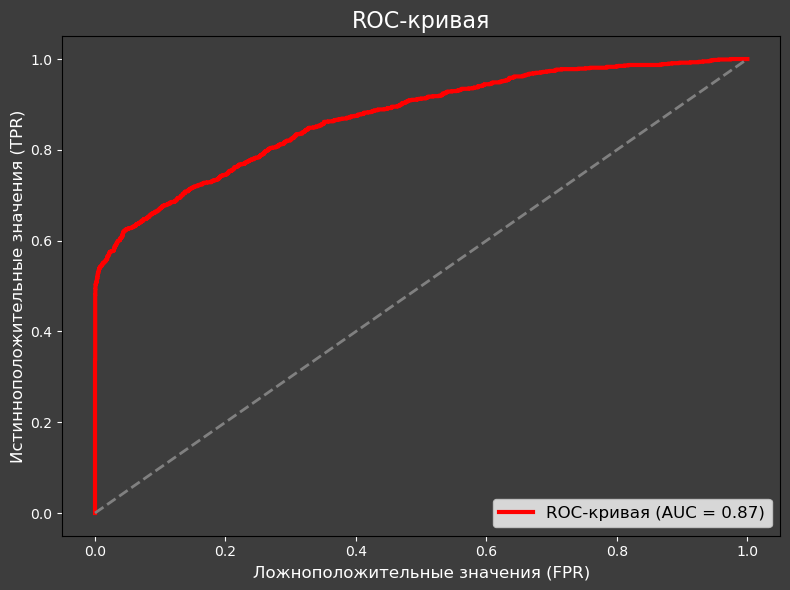

In [23]:
fpr, tpr, thresholds = roc_curve(y_valid, avg_pred_proba)
roc_auc = roc_auc_score(y_valid, avg_pred_proba)

plt.figure(figsize=(8, 6))

plt.plot(fpr, tpr, color='red', lw=3, label=f'ROC-кривая (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')

plt.title('ROC-кривая', fontsize=16, color='white')
plt.xlabel('Ложноположительные значения (FPR)', fontsize=12, color='white')
plt.ylabel('Истинноположительные значения (TPR)', fontsize=12, color='white')
plt.legend(loc='lower right', fontsize=12)

ax = plt.gca()
ax.set_facecolor('#3d3d3d')
plt.gcf().set_facecolor('#3d3d3d')

ax.tick_params(axis='both', colors='white')

plt.tight_layout()
plt.show()

In [24]:
print(classification_report(y_valid, avg_pred))

              precision    recall  f1-score   support

           0       0.90      0.99      0.94      4244
           1       0.91      0.55      0.69       991

    accuracy                           0.90      5235
   macro avg       0.91      0.77      0.82      5235
weighted avg       0.91      0.90      0.90      5235



In [25]:
report = classification_report(y_valid, avg_pred, output_dict=True)

f1 = report["1"]["f1-score"]
accuracy = report["accuracy"]
precision = report["1"]["precision"]
recall = report["1"]["recall"]

print(f"Accuracy {accuracy:.2f}")
print(f"Recall {recall:.2f}")
print(f"Precision {precision:.2f}")
print(f"F1-score {f1:.2f}")

Accuracy 0.90
Recall 0.55
Precision 0.91
F1-score 0.69


In [26]:
confusion_matrix(y_valid, avg_pred)

array([[4190,   54],
       [ 445,  546]])

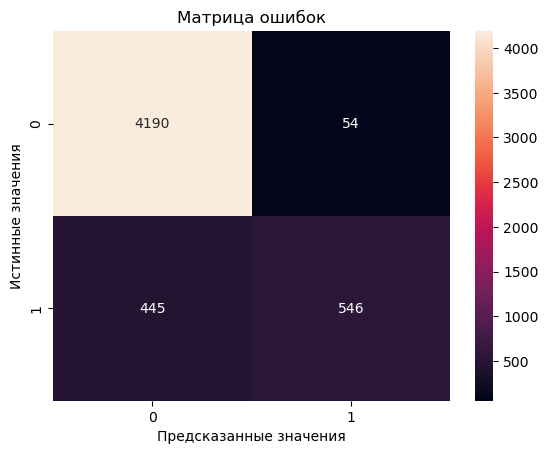

In [27]:
sns.heatmap(confusion_matrix(y_valid, avg_pred), annot=True, fmt='.0f')
plt.xlabel('Предсказанные значения')
plt.ylabel('Истинные значения')
plt.title('Матрица ошибок')
plt.show()

## Обучение финальной модели и Предсказание

In [21]:
test_size = 0.15
models = create_models(best_hyp)
for idx, model in enumerate(models, start=1):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=test_size, random_state=model.random_seed_, shuffle=True)
    
    print(f"Training Model {idx} on {1-test_size:.2f}% of the data")
    model.fit(X_train, y_train, cat_features=cat_features)

In [22]:
proba_preds = [model.predict_proba(data_test.drop(columns=['№ брони']))[:, 1] for model in models]
avg_proba = np.mean(proba_preds, axis=0)

In [23]:
pd.DataFrame(avg_proba).to_csv('out-d.csv', index=None, header=False)